# Code challenge: self-supervised learning and embeddings generation
### General approach
To address this challenge, we will take the following approach:
* Customise a pre-trained encoder (ResNet18) with a projection head (e.g. a multi-layer perceptron (MLP) with one hidden layer), closely following the approach of [Chen et al. (2020), *A Simple Framework for Contrastive Learning of Visual Representation*](https://arxiv.org/pdf/2002.05709), i.e. the SimCLR approach.
* Use SimCLR to conduct semi-supervised training of this custom model, using augmented versions of the data *without* labels.
* After the SimCLR step, discard the projection head, retain the encoder and its weights, and add a new 3-class classifier. This new model will be fine-tuned using labelled data.
* Evaluate the predictive performance of the new model by fine-tuning in the context of 5-fold cross-validation, using training data *with* labels.
* If the cross-validation metrics are positive (e.g. consistent validation accuracy between folds), then proceed with fine-tuning the pre-trained model on the labelled training dataset. If not, then investigate and diagnose possible issues in the pipeline. 
* Evaluate the performance of the fine-tuned model on a hold-out, unseen test set of labelled data.
* Demonstrate embeddings of the model output in a 2D feature-space representation.
### Import libraries and modules:

In [63]:
import math
import random
import numpy as np
import copy # for creating deep copies of pytorch objects
from PIL import Image # handling images
import matplotlib.pyplot as plt # plotting
import torch # machine learning
import torch.nn as nn # module for neural networks
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as tvtran # module for transformations to transform / augment data 
import torchvision.datasets as tvdat # module for handling datasets
from torchvision.models import resnet18, ResNet18_Weights # pre-trained encoder
import torch.nn.functional as F # cross-entropy loss
from sklearn.manifold import TSNE # dimension reduction
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # model metrics
from sklearn.model_selection import StratifiedKFold # cross-validation
import seaborn as sns # visualisation

# set random seeds for reproducibility
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

### Dataset loading
We begin by loading the dataset of pet images from the root folder. Within the directory `\data` are subfolders `\Chinchilla`, `\Hamster` and `\Rabbit`. The `torchvision.datasets.ImageFolder()` function respects this folder structure and automatically assigns class labels to each image accordingly. 

In [2]:
x_raw = tvdat.ImageFolder('D:/LearningChallenge/challenge5/data/', transform=None) 

We can view the set of class labels automatically assigned to images, based on the folder structure:

In [3]:
classes = x_raw.classes

print(classes)

['Chinchilla', 'Hamster', 'Rabbit']


### Splitting the dataset
For this task, we split the data into three partitions: 
* Training data: This dataset will be used *without* labels for self-supervised training using the SimCLR approach, and it will also be used *with* labels for cross-validation and fine-tuning.
* Testing data: This labelled dataset will be used to test the performance of the fine-tuned model on unseen data.

*N.B. The proportions specified below are arbitrary. The effects of adjusting these on the final accuracy could be explored systematically.*

In [70]:
# proportions for data split
prop_train = 0.7
prop_test = 1 - prop_train 

train_size = int(prop_train*len(x_raw)) # size of training set 

test_size = len(x_raw) - train_size # size of the non-training set

# generate training set and testing set
x_train, x_test = torch.utils.data.random_split(x_raw, [train_size, test_size]) 

The dataset sizes are as follows:

In [71]:
print(len(x_train), len(x_test))

167 72


### Dataset augmentation
Next we specify a set of transformations that will be applied to the training data to enable contrastive learning, based on recommendations in the SimCLR paper, see Appendix A [Chen et al. (2020)](https://arxiv.org/pdf/2002.05709). Note that these transformations are stochastic. 

In [6]:
transforms_simclr = tvtran.Compose([
    # spatial transformations
    tvtran.RandomResizedCrop(size=224), # random crop, resized to 224x224
    tvtran.RandomHorizontalFlip(p=0.5), # flip horizontally 50% of the time
    # colour distortion
    tvtran.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), # illustrative parameters
    tvtran.RandomGrayscale(p=0.2), # convert to greyscale with probability 20%
    tvtran.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # illustrative parameters
    # convert to tensor
    tvtran.ToTensor()
])

The SimCLR approach requires two augmented versions of each image using the stochastic transformations specified above. We define a class for generating a customised dataset of these augmented pairs, using the base class `torch.utils.data.Dataset`:

In [7]:
class SimCLR_custom_dat(torch.utils.data.Dataset):
    """Create a custom dataset of augmented image pairs for use in SimCLR, based on base class torch.utils.data.Dataset."""
    def __init__(self, dataset, transform):
        """Initialise the custom dataset.
        
        Args:
            dataset (instance of torch.utils.data.Dataset): Dataset of images.
            transform (instance of torchvision.transforms.Compose): Set of transformations to apply to images. 
        """
        self.dataset = dataset
        self.transform = transform
       
    def __len__(self):
        """Length of custom dataset.

        Returns:
            len(self)
        """
        return len(self.dataset)
        
    def __getitem__(self, idx):
        """Draw a pair of augmented versions of raw image with index idx.
        
        Args:
            idx (int): Index of image, for which to generate a pair of augmented images.

        Returns:
            x1: First stochastic augmentation of image indexed idx.
            x2: Second stochastic augmentation of image indexed idx.
            label: Class label of image indexed idx.
        """
        img, label = self.dataset[idx] # image and label from dataset
        # apply two stochastic augmentations to the same image
        x1 = self.transform(img)
        x2 = self.transform(img)

        return x1, x2, label

Now, we can generate our customised dataset of augmented (and challenging) images, to use in contrastive learning. Note that this dataset consists of augmented versions of the training set, `x_train`. Labels are retained in the dataset, but they will not be used in the training process.

In [8]:
x_simclr = SimCLR_custom_dat(x_train, transforms_simclr) # augmented training dataset for use in SimCLR

Each element of `x_simclr` consists of two augmented versions of the same image, i.e. *positive pairs*, as well as the class label.

### Example augmented images
Below, we plot an image from the original dataset and two augmented versions:

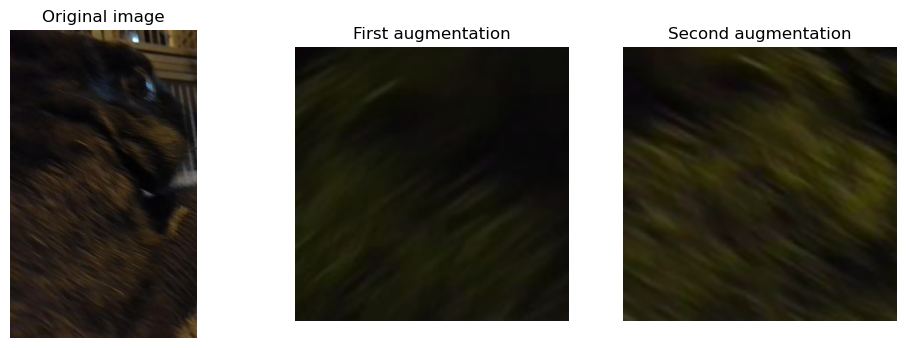

In [72]:
# example of one PIL image and two augmented versions (torch tensors) for plotting
plot_objs = [x_train[0][0], x_simclr[0][0], x_simclr[0][1]]

titles = ['Original image', 'First augmentation', 'Second augmentation'] # plot titles

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for ax, obj, title in zip(axes, plot_objs, titles):
    if isinstance(obj, Image.Image):
        # convert image to numpy array, HxWxC
        arr = np.array(obj)
        ax.imshow(arr)
    else: 
        # for torch tensors, convert CxHxW to HxWxC
        img = obj.numpy() # convert from torch tensor to numpy array
        img = img.transpose(1,2,0) # place colour C last
        ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

### Data loader
Next, we create a data loader for feeding batches of images into the model. We shuffle the dataset, and use the option `drop_last=True` to make sure that incomplete batches are not used. 

*Note that shuffling reorders the dataset so that class labels are not sequential, it does not break the positive pair structure of the dataset. That is, every batch drawn from `train_loader` will consist of `batch_size_simclr` pairs.*

In [10]:
batch_size_simclr = 24 # this is a hyper-parameter that may be tweaked later

simclr_loader = torch.utils.data.DataLoader(x_simclr, batch_size=batch_size_simclr, shuffle=True, drop_last=True) # data loader

To view the content of the data loader, we can inspect its elements. Each element `x` contains two tensors, `x[0]` and `x[1]`, each built of `batch_size_simclr` image tensors. The corresponding i'th element in each is a positive pair. The final component, `x[2]`, lists the class labels for each of the `batch_size_simclr` positive pairs.

In [11]:
for x in simclr_loader:
    print(x[0].shape, x[1].shape, x[2])

torch.Size([24, 3, 224, 224]) torch.Size([24, 3, 224, 224]) tensor([2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 2])
torch.Size([24, 3, 224, 224]) torch.Size([24, 3, 224, 224]) tensor([2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 0, 2, 1, 1])
torch.Size([24, 3, 224, 224]) torch.Size([24, 3, 224, 224]) tensor([0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1])
torch.Size([24, 3, 224, 224]) torch.Size([24, 3, 224, 224]) tensor([2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2])
torch.Size([24, 3, 224, 224]) torch.Size([24, 3, 224, 224]) tensor([2, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([24, 3, 224, 224]) torch.Size([24, 3, 224, 224]) tensor([2, 0, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0])


### Modelling framework
The framework specified in [Chen et al. (2020)](https://arxiv.org/pdf/2002.05709) consists of two main components:
* A base encoder framework, to create feature representations of the augmented data (denoted `f` in the paper, see Fig. 2).
* A projection head (denoted `g`), which maps the features generated by `f` to new vectors, which are used for contrastive learning. 

### Base encoder
For the base encoder, we will use ResNet18 together with a set of pre-trained weights. This model is a relatively small network, to show proof-of-concept without requiring large compute resources. The pre-trained weights provide the initial values used in the self-supervised SimCLR step.

In [12]:
f = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # load ResNet18 as the base encoder, together with pre-trained weights

ResNet18 has 1000 classes of animals in its output layer. These are not relevant to our task, so we truncate the base model to remove the final classification layer. The output of this truncated version will be the penultimate layer of ResNet18 (the average pooling layer), which yields a 512-dimensional feature vector for each image.

In [13]:
f.fc = nn.Identity() # remove final ResNet18 classification layer, fc (i.e. set it to equal Identity())

### Projection head
The projection head `g` is a small neural network that maps the representations generated by `f` to the space where contrastive loss is applied. Following Chen et al. (2020), we define `g` to be a multi-layer perceptron with one hidden layer, a non-linear activation function, and an output of dimension 128. This dimension is adaptable, however we will use 128 as the dimension of the latent space.

In [14]:
g = nn.Sequential(
    nn.Linear(512, 512), # hidden layer
    nn.ReLU(), # activation function
    nn.Linear(512, 128) # output layer; follow Chen et al. (2020) in using 128-dim output
)

### Combined model
Next, we use the pytorch base class `torch.nn.Module` to define our custom neural network architecture, which will combine the encoder `f` with the projection head `g`:

In [15]:
class CustomModel(nn.Module):
    """Create a neural network model by combining a backbone encoder and a projection head."""
    def __init__(self, backbone, head):
        """Initialise the model.

        Args:
            backbone (pytorch neural network): Deep neural network encoder model for feature extraction, to form the backbone of the model.
            head (pytorch neural network): Neural network projection head, to map output of backbone to desired feature space. 
        """
        super().__init__()
        self.backbone = backbone
        self.head = head
        
    def forward(self, x):
        """Forward pass of neural network.

        Args:
            x: A batch of images from a data loader object.

        Returns:
            z: The output of applying first the backbone, and second the head, to x, i.e. z=g(f(x)).
        """
        h = self.backbone(x) # representation of x generated by the backbone; shape: [batch, 512, 1, 1] for ResNet18
        z = self.head(h) # apply head
        return z

Next, we create an instance of our model, for use in the SimCLR algorithm:

In [16]:
model = CustomModel(f, g) # following the SimCLR approach of Chen et al. (2020)

### Self-supervised training using SimCLR
Our strategy is to use the pre-trained ResNet18 weights as the initial values of the encoder for the self-supervised training step. Therefore, we allow them to be changed by unfreezing all parameters in `backbone`. We also ensure all parameters in `head` are unfrozen. 

In [17]:
# unfreeze all layers in the ResNet18 backbone of the model
for param in model.backbone.parameters():
    param.requires_grad=True

# unfreeze the head for training
for param in model.head.parameters():
    param.requires_grad=True

Next, we specify the device on which the training will occur (CPU will be used here for demonstration):

In [18]:
# move model to CPU (assumed by default here, but provided for demonstration)
device = torch.device('cpu')

model = model.to(device)

We use the Adam optimizer for training, and impose a lower learning rate for the pre-trained backbone than for the projection head. The idea here is to try to preserve information from pre-training.

(*N.B. the chosen learning rates are illustrative. The effects of learning rate on performance could be explored systematically.*)

In [19]:
optimizer_simclr = torch.optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-4}, # for backbone
    {'params': model.head.parameters(), 'lr': 1e-3} # for head
]) # use Adam optimizer with lower learning rate (lr) for backbone than for head, to help preserve information in pre-trained model

Now, we are ready to train the customised model using the training dataset. In the training loop below, for each epoch we take each pair of image batches from the data-loader, and project them into the 128-dim representations generated by the model. We then compute the normalized temperature-scaled cross entropy loss (NT-Xent) between pairs of representations (see equation (1) in [Chen et al. (2020)](https://arxiv.org/pdf/2002.05709)). The NT-Xent loss uses the cosine similarity between the representations in both its numerator and denominator, and incorporates a temperature parameter, which in the loop below is held constant. The final loss for each epoch is calculated across all positive pairs. 

*N.B. Temperature is a hyper-parameter that can be set to change according to a pre-defined scheme, or adaptively. It will remain constant below.*

Code for calculating NT-Xent is adapted from [this link](https://github.com/dhruvbird/ml-notebooks/blob/main/nt-xent-loss/NT-Xent%20Loss.ipynb).

In [20]:
epochs = 500 # small number due to time and compute constraints
tau = 0.5 # temperature for calculating NT-Xent; illustrative value; held constant here, but could be defined as a schedule

# self-supervised training loop using SimCLR
for epoch in range(epochs):
    model.train() # switch to train mode
    
    epoch_loss = 0.0 # initialise total loss for this epoch; will be updated after calculation of NT-Xent for each batch
    epoch_acc = 0.0 # initialise contrastive accuracy counter for epoch; updated with epoch_loss

    # load batches and calculate NT-Xent
    for (x1, x2, _) in simclr_loader: # feed in 2 image batches, x1 and x2; ignore labels
        optimizer_simclr.zero_grad() # initialise optimizer

        z1 = model(x1) # 128-dim projections of first batch; shape: [batch_size_simclr, 128]
        
        z2 = model(x2) # 128-dim projections of second batch; shape: [batch_size_simclr, 128]

        z = torch.cat([z1, z2]) # concatenate projections into a tensor of shape [2*batch_size_simclr, 128]

        # calculate pairwise cosine similarity
        z = F.normalize(z, dim=1) # normalize embeddings
        sim_matrix = torch.matmul(z, z.T) # similarity matrix (cosine because normalized)
        
        # mask out diagonal elements of matrix, so they don't contribute to NT-Xent calculation
        sim_matrix[torch.eye(2*batch_size_simclr, device=z.device).bool()] = float("-inf")

        # create labels for positive pairs
        pos_index = list(range(batch_size_simclr, 2*batch_size_simclr)) + list(range(0, batch_size_simclr))
        
        pos_index = torch.tensor(pos_index, device=z.device)

        # calculate cross-entropy loss (scaled by temperature, tau)
        xen = F.cross_entropy(sim_matrix / tau, pos_index, reduction="mean")
        
        xen.backward() # calculate gradients
        
        optimizer_simclr.step() # update the model

        # update total loss for this epoch
        epoch_loss += xen.item()

        # calculate contrastive accuracy for this batch
        with torch.no_grad():
            preds = sim_matrix.argmax(dim=1) # predicted classes
            correct = (preds == pos_index).float().sum().item() # boolean for correctness of each prediction
            total = len(pos_index) # size of batch
            batch_acc = correct / total # accuracy proportion for batch
            epoch_acc += batch_acc # increment accuracy counter
        
    # calculate average loss and contrastive accuracy for this epoch
    avg_loss = epoch_loss / len(simclr_loader)
    avg_acc = epoch_acc / len(simclr_loader)

    if(epoch % 50==0):
        print(f"Epoch [{epoch+1}/{epochs}], NT-Xent Loss: {avg_loss:.4f}, Contrastive Acc: {avg_acc:.4f}")

Epoch [1/500], NT-Xent Loss: 3.5140, Contrastive Acc: 0.2604
Epoch [51/500], NT-Xent Loss: 2.4325, Contrastive Acc: 0.7014
Epoch [101/500], NT-Xent Loss: 2.3170, Contrastive Acc: 0.7951
Epoch [151/500], NT-Xent Loss: 2.2362, Contrastive Acc: 0.8194
Epoch [201/500], NT-Xent Loss: 2.1913, Contrastive Acc: 0.8542
Epoch [251/500], NT-Xent Loss: 2.1858, Contrastive Acc: 0.8681
Epoch [301/500], NT-Xent Loss: 2.1231, Contrastive Acc: 0.9340
Epoch [351/500], NT-Xent Loss: 2.1356, Contrastive Acc: 0.8924
Epoch [401/500], NT-Xent Loss: 2.1144, Contrastive Acc: 0.8750
Epoch [451/500], NT-Xent Loss: 2.0989, Contrastive Acc: 0.9271


Pre-training was run for 500 epochs due to time constraints.

Save the model to file:

In [21]:
torch.save(model.state_dict(), 'D:/LearningChallenge/model_simclr_weights.pth')

### Fine-tuning the model
Following the SimCLR approach, we discard the projection head, `g`, retain the encoder and pre-trained weights, and add a new linear classifier head to the model. We will use the fine-tuning dataset of labelled data to fine-tune the new model using supervised classification. 

First, we define a function to create new copies of the SimCLR-trained encoder for use in the fine-tuning training loop, to prevent the pre-trained model from being modified:

In [27]:
def pretrained_encoder(simclr_mod):
    """Create new copy of pre-trained encoder. 

    Args:
        simclr_mod (pytorch nn): A pytorch model pre-trained using SimCLR.

    Returns:
        model_copy: A new copy of sim_clr with the same weights, but with the SimCLR projection head removed (i.e. set to Identity()).
    """
    model_copy = copy.deepcopy(simclr_mod) # create a deep copy of the SimCLR model
    model_copy.head = nn.Identity() # remove SimCLR projection head
    return model_copy

We do not transform and augment the training data as we did for the SimCLR pre-training. However, we do need to crop the images to the correct dimension for the model (224x224) and convert them to tensors:

In [28]:
transforms_simple = tvtran.Compose([
    tvtran.RandomResizedCrop(size=224), # random crop, resized to 224x224
    tvtran.ToTensor() # convert to tensor
])

Next, we create a custom dataset for this labelled data, which can be used for the fine-tuning and evaluation steps:

In [ ]:
# create a custom dataset for this data
class custom_dat_labelled(torch.utils.data.Dataset):
    """Create a custom dataset of cropped tensors for the raw images, based on base class torch.utils.data.Dataset."""
    
    def __init__(self, dataset, transform):
        """Initialise the custom dataset.
        
        Args:
            dataset (instance of torch.utils.data.Dataset): Dataset of images.
            transform (instance of torchvision.transforms.Compose): Set of transformations to apply to images. 
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        """Length of custom dataset.

        Returns:
            len(self)
        """
        return len(self.dataset)
        
    def __getitem__(self, idx):
        """Transform raw image with index idx.
        
        Args:
            idx (int): Index of image to transform.

        Returns:
            x: Transformed image idx.
            label: Class label of image indexed idx.
        """
        img, label = self.dataset[idx] # image and label from dataset
        x = self.transform(img)
        return x, label

Using this custom dataset, we create an instance of the training set for fine-tuning and extract the labels:

In [37]:
# create the dataset
x_ft = custom_dat_labelled(x_train, transforms_simple)

# extract the labels
y_ft = [label for _, label in x_ft] 

For fine-tuning, we will use 5-fold cross-validation (CV). Cross-entropy loss between model output and ground-truth labels will be used. A data-loader will be created for each training fold, within the cross-validation loop.

Define functions for training and evaluating within the CV loop:

In [73]:
# training function to be used for fine-tuning
def ft_train_one_epoch(mod, optimizer, loader, device):
    """Train the model for one epoch.

    Args:
        mod (pytorch nn): Model to be trained.
        optimizer (pytorch optimizer): Optimizer to by used for training.
        loader (pytorch data loader): Data loader for training data.
        device: Device on which training will be performed (CPU in this case).

    Returns:
        Average loss for epoch; training accuracy (proportion correct classifications)
    """
    mod.train() # switch to train mode
    epoch_loss = 0.0 # initialise variable to keep track of loss for this epoch
    correct = 0 # variable to keep track of number of correct classifications
    
    for x_batch, y_labels in loader: # load batch of images and corresponding labels
        x_batch, y_labels = x_batch.to(device), y_labels.to(device) # send to device (CPU in this case)
        optimizer.zero_grad() # initialise optimizer
        out = mod(x_batch) # apply model to first batch
        loss = F.cross_entropy(out, y_labels) # calculate loss between model output and ground-truth labels
        loss.backward() # calculate gradients
        optimizer.step() # update model weights
        preds = out.argmax(dim=1)
        correct += (preds == y_labels).sum().item()
        epoch_loss += loss.item()* x_batch.size(0) # increment loss for this epoch
        
    return epoch_loss / len(loader.dataset), correct/len(loader.dataset)

In [74]:
# evaluation function to be used in fine-tuning
def ft_evaluate(mod, loader, device):
    """Evaluate the model on the validation split during cross-validation.

    Args:
        mod (pytorch nn): Model to be evaluated.
        loader (pytorch data loader): Data loader for validation data.
        device: Device on which the cross-validation is being performed (CPU in this case).

    Returns:
        Average loss; testing accuracy (proportion correct classifications)
    """
    mod.eval() # switch to evaluation mode
    running_loss = 0.0 # variable to keep track of loss
    correct = 0 # variable to keep track of number of correct classifications
    
    with torch.no_grad(): # don't update model during evaluation
        for x_batch, y_labels in loader: # load batch of data together with ground-truth labels
            x_batch, y_labels = x_batch.to(device), y_labels.to(device) # send to device (CPU)
            out = mod(x_batch) # evaluate model on data batch
            loss = F.cross_entropy(out, y_labels) # calculate cross-entropy loss between model output and ground-truth labels 
            running_loss += loss.item() * x_batch.size(0) # update loss
            preds = out.argmax(dim=1) # get class predictions 
            correct += (preds == y_labels).sum().item() # update number of correct predictions
            
    return running_loss / len(loader.dataset), correct / len(loader.dataset)

Now we fine-tune the model, using these functions within a 5-fold cross-validation loop:

In [45]:
epoch_ft = 8 # number of epochs to run for each fold

batch_size_ft = 32 # batch size

n_folds = 5 # number of folds in CV

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=123) # use stratified k-fold CV to mitigate class imbalance

fold_results = {} # initialise to store results of CV

for fold, (train_idx, val_idx) in enumerate(kf.split(x_ft, y_ft)):
    print(f"\n--- Fold {fold + 1}/{n_folds} ---")

    # initialise pre-trained model for fold
    encoder_ft = pretrained_encoder(model) # create a deep copy of the pre-trained model with the project head removed 
    model_fold = CustomModel(encoder_ft, nn.Linear(512, 3)) # add a new 3-class classification head
    model_fold.to(device) # send to device (CPU in this case)

    # initialise optimizer for fold
    optimizer_fold = torch.optim.Adam([
        {'params': model_fold.backbone.parameters(), 'lr': 1e-4}, # for backbone
        {'params': model_fold.head.parameters(), 'lr': 1e-4} # for head
    ]) # use Adam optimizer with lower learning rate (lr) for backbone than for head, to help preserve information in pre-trained model
    
    # initialize learning rate scheduler for this fold
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fold, step_size=5, gamma=0.5)

    # create data loaders for this fold
    train_subset = Subset(x_ft, train_idx) # training set for this fold
    val_subset = Subset(x_ft, val_idx) # validation set for this fold
    
    train_loader = DataLoader(train_subset, batch_size=batch_size_ft, shuffle=True) # data loader for training set
    val_loader = DataLoader(val_subset, batch_size=batch_size_ft) # data loader for validation set

    # training loop
    best_val_acc = 0.0 # initialise variable to keep track of best validation accuracy
    
    for epoch in range(epoch_ft): 
        train_loss, train_acc = ft_train_one_epoch(model_fold, optimizer_fold, train_loader, device) # calculate training loss and accuracy for epoch
        
        val_loss, val_acc = ft_evaluate(model_fold, val_loader, device) # calculate loss and accuracy for validation set

        lr_scheduler.step() # update learning rates according to step_size and gamma
        
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc # update best validation accuracy so far

    fold_results[f"fold_{fold+1}"] = best_val_acc

# summarize results
print("\nCross-validation results:")
for fold, acc in fold_results.items():
    print(f"{fold}: {acc:.4f}")


--- Fold 1/5 ---
Epoch 1: Train Loss=1.2442, Train Acc=0.3383, Val Loss=0.5639, Val Acc=0.8824
Epoch 2: Train Loss=0.6490, Train Acc=0.7218, Val Loss=0.3792, Val Acc=0.9118
Epoch 3: Train Loss=0.3751, Train Acc=0.9098, Val Loss=0.2645, Val Acc=0.9412
Epoch 4: Train Loss=0.2428, Train Acc=0.9474, Val Loss=0.3903, Val Acc=0.9118
Epoch 5: Train Loss=0.1857, Train Acc=0.9549, Val Loss=0.3066, Val Acc=0.9412
Epoch 6: Train Loss=0.1308, Train Acc=0.9925, Val Loss=0.3162, Val Acc=0.8824
Epoch 7: Train Loss=0.1255, Train Acc=0.9925, Val Loss=0.2500, Val Acc=0.9118
Epoch 8: Train Loss=0.1368, Train Acc=0.9699, Val Loss=0.2407, Val Acc=0.9118

--- Fold 2/5 ---
Epoch 1: Train Loss=1.5129, Train Acc=0.2707, Val Loss=0.6811, Val Acc=0.7059
Epoch 2: Train Loss=0.7770, Train Acc=0.6241, Val Loss=0.3731, Val Acc=0.9118
Epoch 3: Train Loss=0.4752, Train Acc=0.8647, Val Loss=0.2855, Val Acc=0.9118
Epoch 4: Train Loss=0.2663, Train Acc=0.9699, Val Loss=0.2785, Val Acc=0.8824
Epoch 5: Train Loss=0.1626, 

### Discussion of cross-validation
The cross-validation process indicates that for every fold, training and validation loss decreases in general. The loss values can be unstable, which could be a consequence of several factors, such as the dataset being small, batch sizes being too small, or learning rates being non-optimal. These latter issues could be investigated systematically, if more time were available. 

Also, we see that both training accuracy and validation accuracy are generally very good. They reach 100% in some places, which could indicate that the model is over-fitting, which is possible since the model has high capacity yet the dataset is small. Ideally we would expand our dataset to help mitigate the risk of over-fitting. That said, the 100% accuracies are only achieved in some folds, not across all folds. This suggests that the issue may be less to do with overfitting, and more likely an artefact of having unbalanced classes in the relatively small training/testing splits for those folds. A stratified cross-validation scheme was employed to help mitigate the unbalanced classes, however further investigation would be required to fully diagnose and fix this issue.

### Creating a "final" model
Overall, cross-validation indicates that the model generalises well across different dataset splits. We therefore follow the standard process of now re-training the model on the full training dataset, which will give us a *"final"* model. This is achieved in the following training loop:

In [48]:
encoder_final = pretrained_encoder(model) # instantiate the pre-trained encoder
model_final = CustomModel(encoder_final, nn.Linear(512, 3)) # add a 3-class classifier head
model_final.to(device) # send the model to device (CPU in this case)

final_loader = DataLoader(x_ft, batch_size=32, shuffle=True) # data loader for training

# optimiser for final model training
optimizer_final = torch.optim.Adam([
    {'params': model_final.backbone.parameters(), 'lr': 1e-4},
    {'params': model_final.head.parameters(), 'lr': 1e-3}
])

# learning rate scheduler for model training
scheduler_final = torch.optim.lr_scheduler.StepLR(optimizer_final, step_size=5, gamma=0.75)

# final training loop
epoch_final = 30

for epoch in range(epoch_final):
    train_loss_final, train_acc_final = ft_train_one_epoch(model_final, optimizer_final, final_loader, device)
    
    scheduler_final.step()
    
    print(f"Final Model Epoch {epoch+1}: Loss={train_loss_final:.4f}, Acc={train_acc_final:.4f}")


Final Model Epoch 1: Loss=0.7991, Acc=0.6407
Final Model Epoch 2: Loss=0.2377, Acc=0.9222
Final Model Epoch 3: Loss=0.1459, Acc=0.9701
Final Model Epoch 4: Loss=0.0917, Acc=0.9701
Final Model Epoch 5: Loss=0.0923, Acc=0.9820
Final Model Epoch 6: Loss=0.0476, Acc=0.9880
Final Model Epoch 7: Loss=0.0331, Acc=1.0000
Final Model Epoch 8: Loss=0.0388, Acc=0.9940
Final Model Epoch 9: Loss=0.0677, Acc=0.9760
Final Model Epoch 10: Loss=0.0558, Acc=0.9880
Final Model Epoch 11: Loss=0.0248, Acc=0.9940
Final Model Epoch 12: Loss=0.0485, Acc=0.9820
Final Model Epoch 13: Loss=0.0373, Acc=0.9940
Final Model Epoch 14: Loss=0.0293, Acc=0.9940
Final Model Epoch 15: Loss=0.0494, Acc=0.9760
Final Model Epoch 16: Loss=0.0281, Acc=0.9940
Final Model Epoch 17: Loss=0.0355, Acc=0.9880
Final Model Epoch 18: Loss=0.0228, Acc=0.9880
Final Model Epoch 19: Loss=0.0137, Acc=1.0000
Final Model Epoch 20: Loss=0.0244, Acc=0.9940
Final Model Epoch 21: Loss=0.0282, Acc=0.9940
Final Model Epoch 22: Loss=0.0277, Acc=0.99

Save the fine-tuned model for later analysis:

In [49]:
torch.save(model_final.state_dict(), 'D:/LearningChallenge/model_finetuned_weights.pth')

### Evaluating and visualising performance
Now that we have a fine-tuned model, we can evaluate and visualise its performance. We will do the following:
* Apply the fine-tuned model to the hold-out test dataset, and calculate the classification accuracy on this unseen data.
* Apply the fine-tuned model to the entire original dataset, not for evaluation but for visualisation.
* Collect the 512-dim feature vectors for each data item generated by the fine-funed backbone, for both the test and full datasets.  
* Perform dimension reduction on the 512-dim representations, using t-distributed stochastic neighbour embedding (t-SNE).
* Plot 2D t-SNE representations of both the full dataset and the test dataset, colour-coding points according to pet class (chinchilla, hamster or rabbit). 

In [75]:
# create evaluation and full datasets using same simple transformations as for the fine-tune set
x_test = custom_dat_labelled(x_test, transforms_simple)

x_full = custom_dat_labelled(x_raw, transforms_simple)

Run the unseen testing data through the fine-tuned model, collect the 512-dim feature vectors and the predicted model classifications, together with the ground-truth class labels:

In [83]:
# switch model to evaluation mode
model_final.eval()

# lists to store image features, labels, and actual / predicted classes
all_features = []
all_labels = []
outputs = []
actual = []
predicted = []

# evaluation loop
with torch.no_grad():
    for x, label in x_test:  # iterate through each image in the evaluation dataset 
        img = x.unsqueeze(0).to(device)     
        h = model_final.backbone(x[None,:,:]) # get feature vector from fine-tuned ResNet18 encoder
        res = model_final(x[None,:,:]) # evaluated the model
        outputs.append(res) # collect model output
        actual.append(label) # actual class
        predicted.append(torch.argmax(res, dim=1).item()) # predicted class
        all_features.append(h) # collect features
        all_labels.append(label) # collect labels
        
all_features = np.vstack(all_features)
all_labels = np.array(all_labels)

Calculate accuracy and display the confusion matrix for the *test data*:

In [84]:
accuracy = accuracy_score(actual, predicted)
print(f"Accuracy: {accuracy:.2%}")

cm = confusion_matrix(actual, predicted)
print(cm)

print(classification_report(actual, predicted, target_names=classes))

Accuracy: 97.22%
[[12  0  2]
 [ 0 11  0]
 [ 0  0 47]]
              precision    recall  f1-score   support

  Chinchilla       1.00      0.86      0.92        14
     Hamster       1.00      1.00      1.00        11
      Rabbit       0.96      1.00      0.98        47

    accuracy                           0.97        72
   macro avg       0.99      0.95      0.97        72
weighted avg       0.97      0.97      0.97        72



Next, run the full raw dataset through the fine-tuned model, collect the 512-dim feature vectors and the predicted model classifications, together with the ground-truth class labels:

In [85]:
# switch model to evaluation mode
model_final.eval()

# lists to store image features and labels
all_features_full = []
all_labels_full = []
outputs_full = []
actual_full = []
predicted_full = []

# evaluation loop
with torch.no_grad():
    for x, label in x_full:  # iterate through each image in the evaluation dataset 
        img = x.unsqueeze(0).to(device)    
        h = model_final.backbone(x[None,:,:]) # get feature vector from fine-tuned ResNet18 encoder
        res = model_final(x[None,:,:])
        outputs_full.append(res)
        actual_full.append(label)
        predicted_full.append(torch.argmax(res, dim=1).item())
        all_features_full.append(h)
        all_labels_full.append(label)
        
all_features_full = np.vstack(all_features_full) 
all_labels_full = np.array(all_labels_full)

In [86]:
accuracy_full = accuracy_score(actual_full, predicted_full)
print(f"Accuracy over full dataset: {accuracy_full:.2%}")

cm_full = confusion_matrix(actual_full, predicted_full)
print(cm_full)

Accuracy over full dataset: 97.49%
[[ 42   0   4]
 [  1  33   0]
 [  1   0 158]]


### Visualising the model results
We use t-SNE (with PCA initialisation) to reduce the feature vectors for the test and full datasets to 2 dimensions:

In [88]:
# create t-SNE object to fit to datasets
tsne = TSNE(n_components=2, init='pca', perplexity=10, random_state=123)

# 2D representations of evaluation dataset and full dataset
features_2d_eval = tsne.fit_transform(all_features)  # shape [num_images, 2]
features_2d_full = tsne.fit_transform(all_features_full)  # shape [num_images, 2]

# retrieve ground-truth class labels for each image
classes_eval = [x[1] for x in x_test]
classes_full = [x[1] for x in x_full]

Finally, we plot the 2D feature representations (scatter plots and kernel density estimates for each cluster) for both the full dataset and for the test dataset:

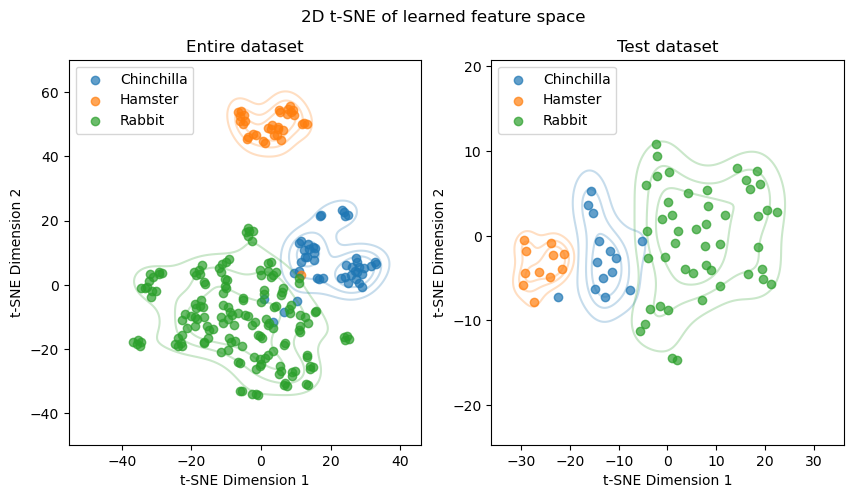

In [91]:
plt.subplots(1, 2, figsize=(10,5))

plt.subplot(1,2,1)
for class_idx, class_full in enumerate(classes):
    pts = features_2d_full[all_labels_full == class_idx]
    sns.kdeplot(x=pts[:,0], y=pts[:,1], alpha=0.25, levels=[0.25, 0.5, 0.75, 1.0])
    plt.scatter(pts[:,0], pts[:,1], label=class_full, alpha=0.7)
plt.legend(loc=2)
plt.title("Entire dataset")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.subplot(1,2,2)
for class_idx, class_eval in enumerate(classes):
    pts = features_2d_eval[all_labels == class_idx]
    sns.kdeplot(x=pts[:,0], y=pts[:,1], alpha=0.25, levels=[0.25, 0.5, 0.75, 1.0])
    plt.scatter(pts[:,0], pts[:,1], label=class_eval, alpha=0.7)
plt.legend(loc=2)
plt.title("Test dataset")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.suptitle('2D t-SNE of learned feature space')

plt.savefig("feature_space_clusters.png")
plt.show()

### Discussion
We have trained a ResNet18 backbone with pre-trained weights using SimCLR, added a linear classifer, fine-tuned the model, evaluated its performance and generated 2D feature embeddings. This satisfies the original task requirement.  

During cross-validation, training and validation accuracies were very high. These are indications of potential over-fitting. However, given so many parameter choices within the pipeline, it has not been possible to systematically investigate over-fitting. If present, it could have resulted from a combination of having a very high-capacity model, together with a small dataset and unbalanced classes. 

However, the accuracy of the final fine-tuned model on the held-out testing dataset of 72 images was 97%, which is very high, particularly for a multi-class problem. This alleviates some concern about model over-fitting, since this data had not previously been seen by the model. This gives confidence that the classifier is working as intended. The classification report indicates precision of 100% for the two smallest classes, Chinchilla and Hamster. Furthermore, F1 scores per class were 0.92, 1.00, 0.98, providing further confidence in strong classifier performance, given the unbalanced class structure.

The visualisation of the t-SNE projections for the full dataset (left-hand panel) provides visual evidence that the fine-tuned model is able to separate the classes Chinchilla, Hamster and Rabbit to a high degree of accuracy. The right-hand panel displays the t-SNE projection for the unseen test data only. This small subset still exhibits clearly defined clusters. 

From the t-SNE clustering, it seems that hamsters are relatively easily distinguished, whereas the classifier struggles to differentiate between some images of chinchillas and rabbits. There is more overlap between their clusters in the t-SNE space. We might conclude that there is more similarity between their features (real physical features and/or data features) than with hamsters. This may be compounded by the fact that the rabbits and one of the two chinchillas are black, the dataset is small and some of the images are of poor quality. 

### Potential extensions
Given more time, I would like to have made several extensions to this project, including:
* Investigating the use of different pre-trained encoder backbones (e.g. ResNet50).
* Running the SimCLR pre-training for longer (i.e. more epochs). This would have been feasible with more time and access to better compute resources (e.g. GPUs).
* Addition of more data. A quick internet search has led to other datasets of relevant pet images. These could potentially be used to bulk up the training set.
* Systematic exploration of hyperparameter space, to identify optimal batch sizes, learning rates, cross-validation parameters etc.
* Re-factoring of code, to make it more reusable.
* Addition of unit tests for each function and class.
* Addition of further documentation to support other users of this code. 
* Monitoring and visualisation of training parameters (e.g. loss and accuracy) using `tensorboard`.
* A more sophisticated fine-tuning approach. For instance, unfreezing layers in sequence during training, rather than simultaneously.